In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def get_data(dataset):
    data = load_svmlight_file("./{}".format(dataset))
    # data = load_svmlight_file("../dataset/australian_scale")
    input_data = data[0].toarray()
    return input_data, data[1]

In [3]:
def initial_w(dimension):
    w = np.zeros((dimension, 1))
    # w = np.random.random((dimension, 1))
    # w = np.random.normal(size=(dimension, 1))
    return w

In [4]:
def plot_test_loss(testing_loss, algorithm, show=False):
    x = np.array(range(1, len(testing_loss)+1))
    plt.figure(0)
    # plt.plot(x, np.array(training_loss), label="train")
    plt.plot(x, np.array(testing_loss), label=algorithm)
    if show==True:
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Experiment")
        plt.grid(True)
        plt.legend()
        plt.show()

In [5]:
def sigmoid(w, X):
    return 1.0/(1.0+np.e**(-np.dot(X, w)))

In [6]:
def main(batch_size, nEpochs, lr):
    # get dataset
    # x_train, x_test, y_train, y_test = get_dataset(input_data, label)
    x_train, y_train = get_data('a9a')
    x_test, y_test = get_data('a9a.t')

    # handle data
    temp = np.zeros((len(x_test), 1))
    x_test = np.column_stack((x_test, temp))
    y_train[y_train==-1] = 0
    y_test[y_test==-1] = 0

    # handle b
    train_column = np.ones((len(x_train), 1))
    x_train = np.column_stack((x_train, train_column))
    test_column = np.ones((len(x_test), 1))
    x_test = np.column_stack((x_test, test_column))

    algorithm = ['SGD', 'NAG', 'RMSProp', 'Adadelta', 'Adam']
    for a in range(len(algorithm)):

        # initialize the w
        w = initial_w(dimension=(123+1))

        # plot
        training_loss_list = []
        testing_loss_list = []

        # number of batch
        num_batch = int(len(x_train)/batch_size + 1)

        # initialize the v(t-1) NAG
        v_t_1 = np.zeros((123+1, 1))
        # initialize the g(t-1) RMSProp
        g_t_1 = np.zeros((123+1, 1))
        # initialize the delta(t-1) AdaDelta
        delta_t_1 = np.zeros((123+1, 1))
        # initialize the v(t-1) and m(t-1) Adam
        v_t_1_a = np.zeros((123+1, 1))
        m_t_1 = np.zeros((123+1, 1))

        for i in range(nEpochs):
            training_loss = 0.0
            testing_loss = 0.0
            # shuffle each batch in different epochs
            shuffle = random.sample(range(len(x_train)), len(x_train))
            for j in range(num_batch):
                # batch
                if j!=num_batch-1:
                    # the data in each batch
                    x = x_train[shuffle[j*batch_size:(j+1)*batch_size]]
                    y = y_train[shuffle[j*batch_size:(j+1)*batch_size]]
                elif j==num_batch-1:
                    # the data in each batch
                    x = x_train[shuffle[j*batch_size:]]
                    y = y_train[shuffle[j*batch_size:]]

                # algorithm
                if algorithm[a]=="SGD":
                    # calculate the gradient
                    grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    # update
                    w = w - lr * grad

                elif algorithm[a]=="NAG":
                    # calculate the gradient
                    grad = (np.dot(np.transpose(x), (sigmoid((w-0.9*v_t_1), x) - y.reshape(-1, 1))))/len(x)
                    v_t = 0.9*v_t_1 + lr * grad
                    # update
                    w = w - v_t
                    v_t_1 = v_t.copy()

                elif algorithm[a]=="Adadelta":
                    # calculate the gradient
                    grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    g_t = grad.copy()
                    g_t = 0.1 * np.square(g_t_1) + 0.9 * np.square(g_t)

                    # update
                    delta_w = (np.sqrt(np.mean(delta_t_1)+0.001)/np.sqrt(np.mean(g_t)+0.001))*grad
                    w = w - delta_w
                    delta_t = 0.9 * delta_t_1 + 0.1 * np.square(delta_w)
                    delta_t_1 = delta_t.copy()

                elif algorithm[a]=="RMSProp":
                    # calculate the gradient
                    grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    g_t = grad.copy()
                    g_t = 0.1 * np.square(g_t_1) + 0.9 * np.square(g_t)

                    # update
                    w = w - (lr*grad)/np.sqrt(np.mean(g_t)+0.001)
                    g_t_1 = g_t.copy()

                elif algorithm[a]=="Adam":
                    # calculate the gradient
                    grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    m_t = 0.9 * m_t_1 + 0.1 * grad
                    v_t_a = 0.999 * v_t_1_a + 0.001 * np.square(grad)
                    m_t_hat = m_t / ( 1 - np.power(0.9, i*num_batch+j+1))
                    v_t_a_hat = v_t_a / ( 1 - np.power(0.999, i*num_batch+j+1))
                    # update
                    w = w - lr * m_t_hat / (np.sqrt(v_t_a_hat) + 1e-8)
                    m_t = m_t_hat
                    v_t_a = v_t_a_hat

                # training error and testing error
                training_loss += -np.mean(y_train.reshape(-1, 1) * np.log(sigmoid(w, x_train)) + (1 - y_train.reshape(-1, 1)) * (np.log(1 - sigmoid(w, x_train))))
                testing_loss += -np.mean(y_test.reshape(-1, 1) * np.log(sigmoid(w, x_test)) + (1 - y_test.reshape(-1, 1)) * (np.log(1 - sigmoid(w, x_test))))
            
            training_loss = training_loss/num_batch
            testing_loss = testing_loss/num_batch
            training_loss_list.append(training_loss)
            testing_loss_list.append(testing_loss)
            print("training error:[{}] testing error:[{}]".format(training_loss, testing_loss))

        # plot
        # plot_loss(training_loss_list, testing_loss_list)
        if a==len(algorithm)-1:
            plot_test_loss(testing_loss=testing_loss_list, algorithm=algorithm[a], show=True)
        else:
            plot_test_loss(testing_loss=testing_loss_list, algorithm=algorithm[a], show=False)

training error:[0.6807016988367453] testing error:[0.6805084759229969]
training error:[0.6625616107893848] testing error:[0.6620751233192936]
training error:[0.6466416165820155] testing error:[0.6458836077232463]
training error:[0.6324811106612225] testing error:[0.6314674674467436]
training error:[0.6201834483105483] testing error:[0.6189381327960417]
training error:[0.6094080887734872] testing error:[0.6079510727863257]
training error:[0.5998341081541496] testing error:[0.5981809705598669]
training error:[0.5912757424153805] testing error:[0.5894401662827579]
training error:[0.5836517061303292] testing error:[0.5816475837860505]
training error:[0.5768721655089999] testing error:[0.5747143439561795]
training error:[0.5707053820641221] testing error:[0.5684027482648384]
training error:[0.565138865341374] testing error:[0.5627026743663981]
training error:[0.560043919370699] testing error:[0.5574826418605927]
training error:[0.5554585917987653] testing error:[0.5527833714810358]
training

training error:[0.42111058176294375] testing error:[0.4174237585825511]
training error:[0.41698928300569843] testing error:[0.4133003502844478]
training error:[0.4132223392233601] testing error:[0.40952607352962894]
training error:[0.4097805802371969] testing error:[0.4060755138190334]
training error:[0.4066328423716337] testing error:[0.4029128677122746]
training error:[0.4037428646406283] testing error:[0.4000113152902832]
training error:[0.40108467845847673] testing error:[0.39734527694887734]
training error:[0.3986324374782256] testing error:[0.39488804629995816]
training error:[0.39635851532467403] testing error:[0.39261415722802967]
training error:[0.3942460597024627] testing error:[0.39050671078243476]
training error:[0.3922688792638175] testing error:[0.3885348791190123]
training error:[0.39042223243156693] testing error:[0.38669621210912575]
training error:[0.388693337532868] testing error:[0.38497181711744244]
training error:[0.3870777868078459] testing error:[0.3833577110542

training error:[0.3494540024138217] testing error:[0.34563096831867823]
training error:[0.3487331874398686] testing error:[0.34492709744169603]
training error:[0.34802926626777964] testing error:[0.34423017544355256]
training error:[0.34736884083683245] testing error:[0.34356416857548777]
training error:[0.34673912307128174] testing error:[0.3429320335518998]
training error:[0.34614972623379486] testing error:[0.34235281280069485]
training error:[0.34557599379900306] testing error:[0.34177327490286324]
training error:[0.34502770585731835] testing error:[0.34123427484649366]
training error:[0.3445087324715443] testing error:[0.34069421425097607]
training error:[0.34400226745595364] testing error:[0.3401980448999653]
training error:[0.34354113823697185] testing error:[0.33974597394716916]
training error:[0.3430710247803685] testing error:[0.33928952568924475]
training error:[0.3426396935267348] testing error:[0.3388510912115211]
training error:[0.3422002508146917] testing error:[0.338406

training error:[0.32870599272950324] testing error:[0.32588260609350234]
training error:[0.32850094537764685] testing error:[0.32569496324242797]
training error:[0.3283373599066927] testing error:[0.325614464475381]
training error:[0.32827070269539116] testing error:[0.32556617640745844]
training error:[0.3280613687076427] testing error:[0.325368382539645]
training error:[0.32801018703330004] testing error:[0.32535231592344704]
training error:[0.327858327344205] testing error:[0.32522990295991094]
training error:[0.3277218284423348] testing error:[0.32512397236888824]
training error:[0.3276295035273529] testing error:[0.3250853688106864]
training error:[0.32758751464800484] testing error:[0.325046760628109]
training error:[0.3275385238331162] testing error:[0.3250008148761854]
training error:[0.32733849206923904] testing error:[0.3248782095293128]
training error:[0.32728200775600547] testing error:[0.32484733459727616]
training error:[0.32724830384254455] testing error:[0.3248312555523

training error:[0.323768708684629] testing error:[0.3253487432678939]
training error:[0.3237947457702408] testing error:[0.3253634480693369]
training error:[0.3239743122856384] testing error:[0.32555237086801236]
training error:[0.32398208896099845] testing error:[0.325589369509656]
training error:[0.3239276386899137] testing error:[0.32552121560137914]
training error:[0.32388785922693575] testing error:[0.3255906111530082]
training error:[0.323909056293584] testing error:[0.325665777122402]
training error:[0.32401207848564956] testing error:[0.3257690476200354]
training error:[0.3239990247111376] testing error:[0.3257898383205619]
training error:[0.32395004087074264] testing error:[0.32586371511229845]
training error:[0.3239356579470273] testing error:[0.3259801266155026]
training error:[0.3239624019854255] testing error:[0.3261533012128971]
training error:[0.32392239355478863] testing error:[0.3259770648312636]
training error:[0.32393219281846275] testing error:[0.3259178021472784]
t

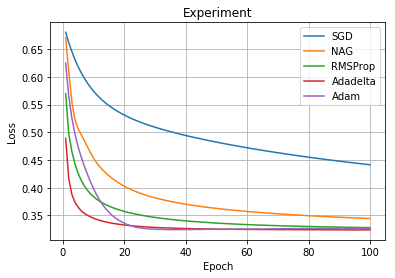

In [7]:
if __name__ == '__main__':
    main(batch_size=10000, nEpochs=100, lr=0.01)